# RQ1 mutation map

## To what extent the sota benchmark is mutable according to wasm-mutate?


In [55]:
# download datasets
# Set DBPASS DBUSER and DBCONN env var to read from the right mongodb
!../analyzer/target/debug/analyzer $DBPASS $DBUSER --collection_name all_wasms --dbconn $DBCONN export all.json
!../analyzer/target/debug/analyzer $DBPASS $DBUSER --collection_name all_wasms_d3d3 --dbconn $DBCONN export all_d3.json

!../analyzer/target/debug/analyzer $DBPASS $DBUSER --collection_name filtered_filtered_all_wasms --dbconn $DBCONN export filtered.json


Exporting
Exporting
Exporting


In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import json

def load_sets(name, find_mutation_info=False, mutation_info_folder=""):
    a = open(name, 'r').read()
    data = json.loads(a)
    
    sets = {}
    
    upto=-1
    for i, t in enumerate(data[:upto]):
        name = t['id']
        mutations = t['mutations']
        
        
        for m in mutations:            
            if find_mutation_info:
                try:
                    m['map'] = open(f"{mutation_info_folder}{m['map']}", "r").read()
                    m['map'] = json.loads(m['map'])
                    
                    if len(m['map'].keys()) == 0: # then there is no practical appliance place
                        continue
                        
                except Exception as e:
                    break
            
            if m['class_name'] not in sets:
                sets[m['class_name']] = []
            sets[m['class_name']].append(t)

   
    for k, v in sets.items():
        print(k, len(v))
    return list(zip(sets.keys(), sets.values())), len(data[:upto])



    
sets, total = load_sets("all.json", find_mutation_info = False)
print(total)

PeepholeMutator::new(2) 21803
CodemotionMutator 21803
AddTypeMutator { max_params: 20, max_results: 20 } 22572
AddFunctionMutator 21961
RemoveSection::Custom 14162
RemoveItemMutator(Item::Function) 21945
RemoveItemMutator(Item::Global) 15801
RemoveItemMutator(Item::Memory) 18843
RemoveItemMutator(Item::Table) 17380
RemoveItemMutator(Item::Type) 21961
CustomSectionMutator 14162
RemoveSection::Empty 225
22572


In [58]:
# import and set figure size
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]



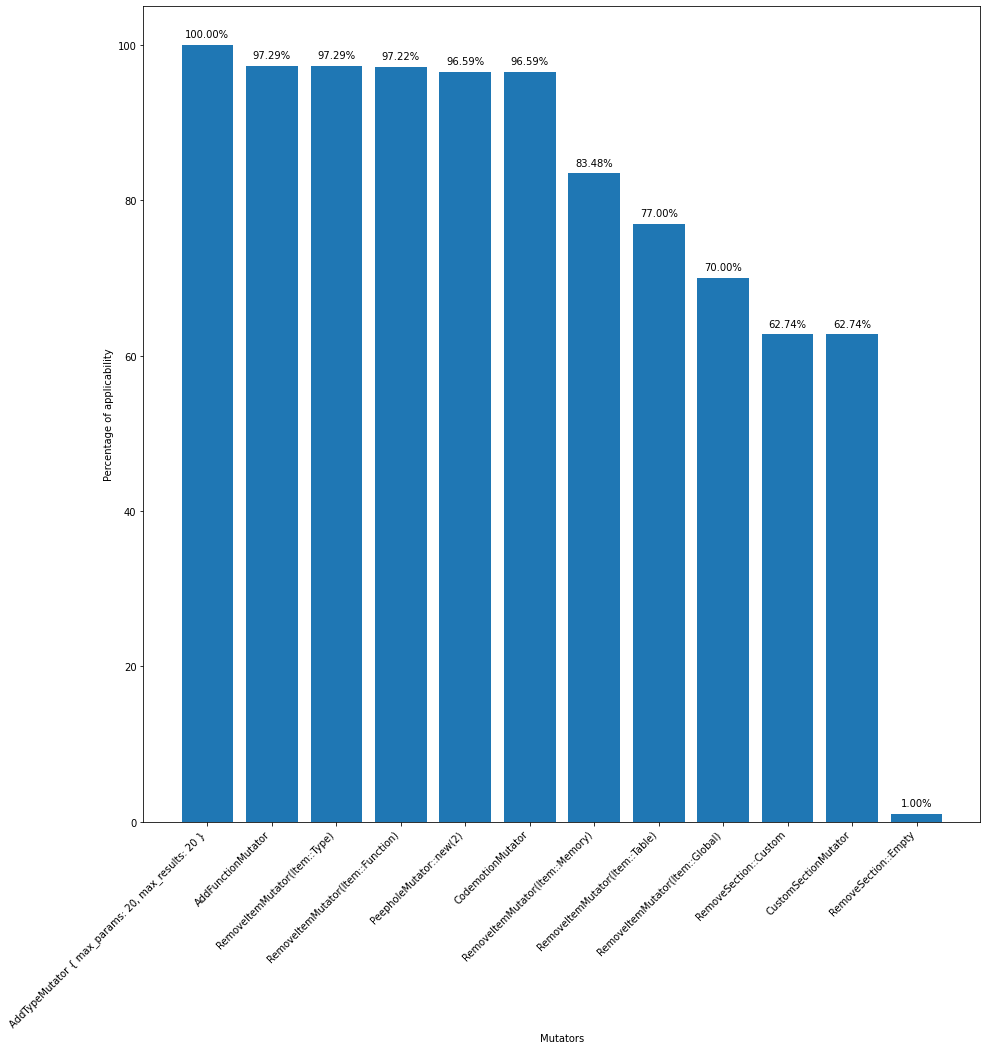

In [59]:
# Plot mutable ratio, for unfiltered dataset

def plot_bars(sets, total):
    bins = [ (k, 100*len(v)/total) for k, v in sets ]
    xs = [ k for k,_ in sets ]

    bins = sorted(bins, key= lambda x: x[1], reverse= True )

    pps = plt.bar([x[0] for x in bins], [x[1] for x in bins])
    for p in pps:
        height = p.get_height()
        plt.text(x=p.get_x() + p.get_width() / 2, y=height+1, s="{:.2f}%".format(height),ha='center')

    plt.xticks(rotation='45',ha='right')
    plt.xlabel("Mutators")
    plt.ylabel("Percentage of applicability")
    
    
plot_bars(sets, total)


### Insights

- A binary can always be mutated by adding a new type definition
- To add a bogus function, the binary needs to have a code section, therefore, only 97.29% of the cases can. The remaining 2.71% of the binaries in the while (unfiltered) has no code section. This is probably due to the presence of test suites
- In 96.59% of the cases a peephole mutator can be applied (the same for the code motion). However, this figure takes into account only the high level validation of the mutator. For example, the code mutator only checks for local defined functions. Thus, we need to go deeper and evaluate how many of the instructions per module (% could be) can be in practice parsed and replaced in the relying egraphs. The same for the code mutator.

- The RemoveSection:Custom can be applied to 62.74% of the binaries. This means, that this mutator can be applied without interfiring with the execution of the binary at all. Usually custom sections only appear to provide debug information, such as function names. This leads us to apply reduce to the dataset to evaluate if in fact even after the manual filtering it still be biased by natural obfuscation.

- On the other hand, some mutation can be applied but the generated module could be invalid and thats how wasm-mutate validates the binary. For example, the remove global mutator can be applied, but only at the validation stage, we could notice if the removed global was used or not.

## Applying the same experiment to already filtered binaries

In [60]:
sets, total = load_sets("filtered.json", find_mutation_info = False)
print(total)

PeepholeMutator::new(2) 8459
CodemotionMutator 8459
AddTypeMutator { max_params: 20, max_results: 20 } 8460
AddFunctionMutator 8460
RemoveItemMutator(Item::Function) 8459
RemoveItemMutator(Item::Global) 6452
RemoveItemMutator(Item::Memory) 8293
RemoveItemMutator(Item::Type) 8460
RemoveSection::Custom 2697
RemoveItemMutator(Item::Table) 7580
CustomSectionMutator 2697
RemoveSection::Empty 126
8460


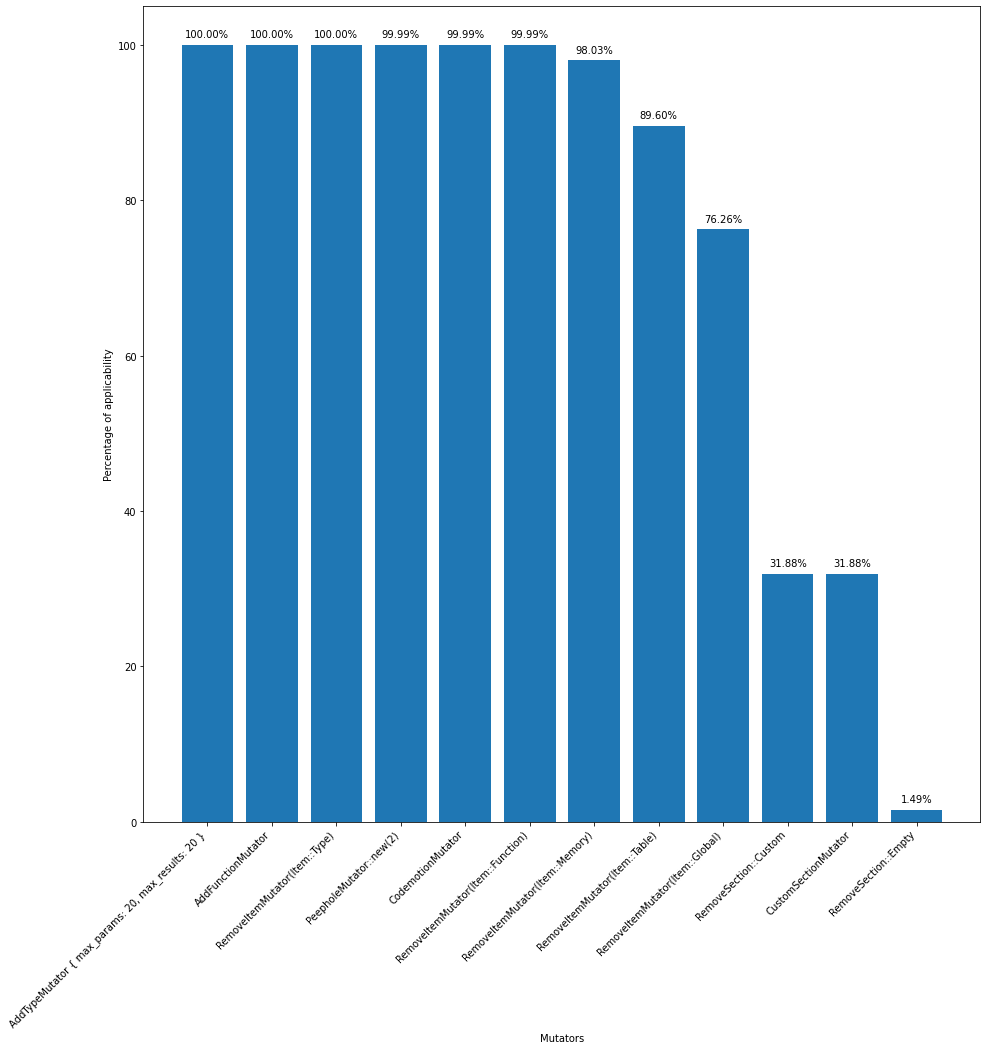

In [61]:
plot_bars(sets, total)

- Interesting, all binaries in the filtered dataset have code section, therefore, we can apply the peephole mutator to all
- Still, RemoveCustomSection can be applied in 32% of the cases. The dataset is probably biased

## Better checking of mutability

In [51]:
sets, total = load_sets("all_d3.json", find_mutation_info = True, mutation_info_folder="")
print(len(sets))
# Print pretty example
# print(json.dumps(sets[2][1][1], indent=4)[:10000])
print("Replacement")
print(sets[2][1][1]['mutations'][0]['map']['0'][0]['meta']['new_tree_display'][:10000])
print("Original")
print(sets[2][1][1]['mutations'][0]['map']['0'][0]['display'][:10000])


RemoveSection::Custom 10
CustomSectionMutator 10
PeepholeMutator::new(2) 3
CodemotionMutator 2
4
Replacement
(i32.add
  (i32.add i32.const.0 i32.const.0)
  (i32.add i32.const.0 i32.const.0))
Original
i32.const.0


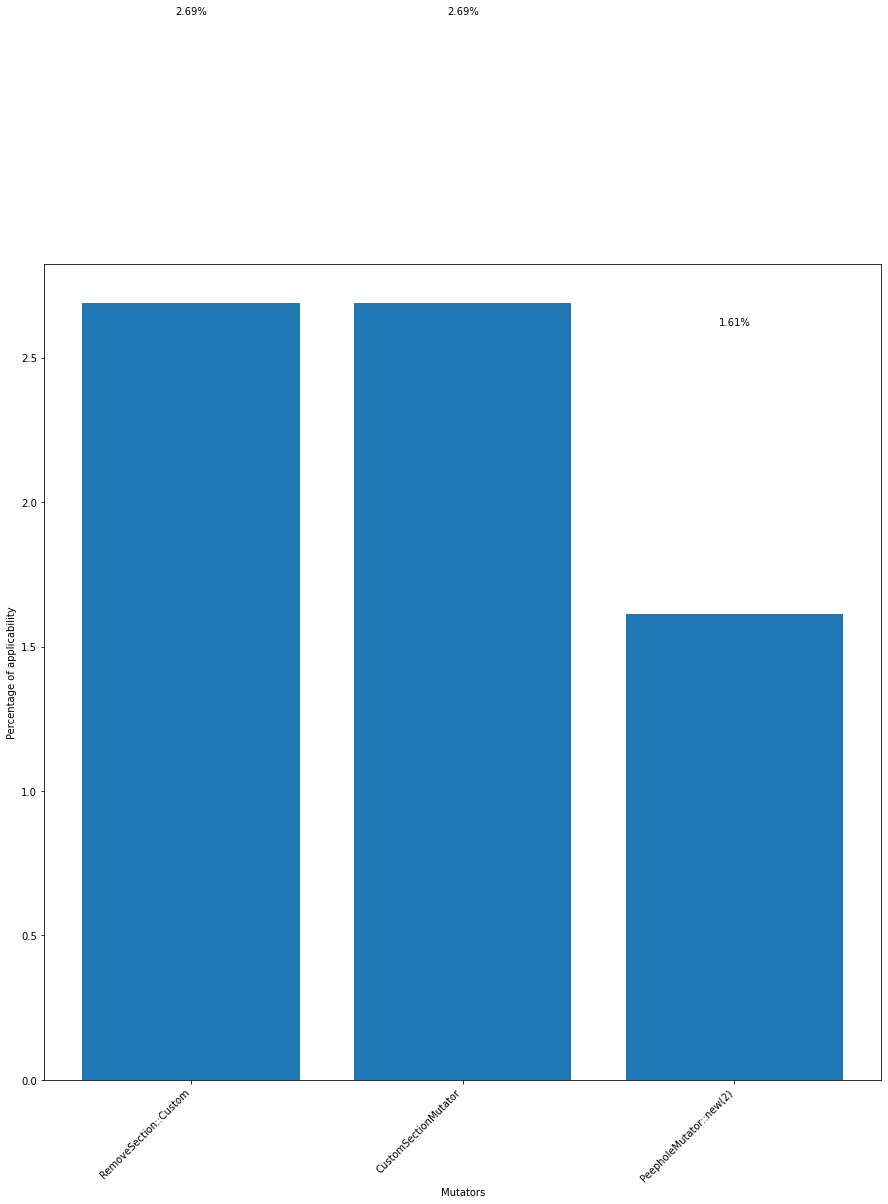

In [43]:
plot_bars(sets, total)